PWC-Net-large model evaluation (on MPI-Sintel 'clean')
=============================================

In this notebook we:
- Evaluate the PWC-Net-large model trained on a mix of the `FlyingChairs` and `FlyingThings3DHalfRes` datasets using the Cyclic<sub>short</sub> schedule
- Run the evaluation on the **'clean'** version of the dataset, yielding an average EPE of 3.99 with pwcnet.ckpt-49000
- Perform basic error analysis

Below, look for `TODO` references and customize this notebook based on your own machine setup.

## Reference

[2018a]<a name="2018a"></a> Sun et al. 2018. PWC-Net: CNNs for Optical Flow Using Pyramid, Warping, and Cost Volume. [[arXiv]](https://arxiv.org/abs/1709.02371) [[web]](http://research.nvidia.com/publication/2018-02_PWC-Net%3A-CNNs-for) [[PyTorch (Official)]](https://github.com/NVlabs/PWC-Net/tree/master/PyTorch) [[Caffe (Official)]](https://github.com/NVlabs/PWC-Net/tree/master/Caffe)

In [1]:
"""
pwcnet_eval.ipynb

PWC-Net model evaluation.

Written by Phil Ferriere

Licensed under the MIT License (see LICENSE for details)
"""
from __future__ import absolute_import, division, print_function
import sys
from copy import deepcopy
import pandas as pd
import seaborn as sns

from dataset_base import _DEFAULT_DS_VAL_OPTIONS
from dataset_mpisintel import MPISintelDataset
from model_pwcnet import ModelPWCNet, _DEFAULT_PWCNET_VAL_OPTIONS
from visualize import display_img_pairs_w_flows

%matplotlib inline

## TODO: Set this first!

In [2]:
# TODO: You MUST set dataset_root to the correct path on your machine!
if sys.platform.startswith("win"):
    _DATASET_ROOT = 'E:/datasets/'
else:
    _DATASET_ROOT = '/media/EDrive/datasets/'
_MPISINTEL_ROOT = _DATASET_ROOT + 'MPI-Sintel'
    
# TODO: Set device on which to perform the evaluation
gpu_devices = ['/device:GPU:0'] # We're doing the evaluation on a single GPU
controller = '/device:GPU:0'

# More options...
mode = 'val_notrain'            # We're doing evaluation using the entire dataset for evaluation
num_samples = 10                # Number of samples for error analysis
ckpt_path = './models/pwcnet-lg-6-2-cyclic-chairsthingsmix/pwcnet.ckpt-49000' # Model to eval

## Load the dataset

In [3]:
# Load the dataset in evaluation mode, starting with the default evaluation options
ds_opts = deepcopy(_DEFAULT_DS_VAL_OPTIONS)
ds_opts['type'] = 'clean'
ds = MPISintelDataset(mode=mode, ds_root=_MPISINTEL_ROOT, options=ds_opts)

In [4]:
# Display dataset configuration
ds.print_config()


Dataset Configuration:
  verbose              False
  in_memory            False
  crop_preproc         None
  scale_preproc        None
  input_channels       3
  type                 clean
  random_seed          1969
  val_split            0.03
  aug_type             None
  mode                 val_notrain


## Configure the evaluation process

In [5]:
# Configure the model for evaluation, starting with the default evaluation options
nn_opts = deepcopy(_DEFAULT_PWCNET_VAL_OPTIONS)
nn_opts['verbose'] = True
nn_opts['ckpt_path'] = ckpt_path
nn_opts['batch_size'] = 1               # Setting this to 1 leads to more accurate evaluations of the processing time 
nn_opts['use_tf_data'] = False          # Don't use tf.data reader for this simple task
nn_opts['gpu_devices'] = gpu_devices
nn_opts['controller'] = controller      # Evaluate on CPU or GPU?

# We're evaluating the PWC-Net-small model in quarter-resolution mode
# That is, with a 6 level pyramid, and uspampling of level 2 by 4 in each dimension as the final flow prediction
nn_opts['use_dense_cx'] = True
nn_opts['use_res_cx'] = True
nn_opts['pyr_lvls'] = 6
nn_opts['flow_pred_lvl'] = 2

# The size of the images in this dataset are not multiples of 64, while the model generates flows padded to multiples
# of 64. Hence, we need to crop the predicted flows to their original size
nn_opts['adapt_info'] = (1, 436, 1024, 2)

In [6]:
# Instantiate the model in evaluation mode and display the model configuration
nn = ModelPWCNet(mode=mode, options=nn_opts, dataset=ds)
nn.print_config()

Building model...
Instructions for updating:
`normal` is a deprecated alias for `truncated_normal`
... model built.
Loading model checkpoint ./models/pwcnet-lg-6-2-cyclic-chairsthingsmix/pwcnet.ckpt-49000 for eval or testing...

INFO:tensorflow:Restoring parameters from ./models/pwcnet-lg-6-2-cyclic-chairsthingsmix/pwcnet.ckpt-49000
... model loaded

Model Configuration:
  verbose                True
  ckpt_path              ./models/pwcnet-lg-6-2-cyclic-chairsthingsmix/pwcnet.ckpt-49000
  x_dtype                <dtype: 'float32'>
  x_shape                [2, None, None, 3]
  y_dtype                <dtype: 'float32'>
  y_shape                [None, None, 2]
  adapt_info             (1, 436, 1024, 2)
  gpu_devices            ['/device:GPU:0']
  controller             /device:GPU:0
  batch_size             1
  use_tf_data            False
  use_mixed_precision    False
  pyr_lvls               6
  flow_pred_lvl          2
  search_range           4
  use_dense_cx           True
  use_res

## Evaluate the model

In [7]:
# Evaluate the performance of the model on the dataset
# Save the predictions to disk for error analysis
# Also, get a panda dataframe with info about each sample for further error analysis
avg_metric, avg_duration, df = nn.eval(metric_name='EPE', save_preds=True)

Measuring EPE and saving preds: 100%|###########################| 1041/1041 [05:42<00:00,  3.04it/s]


In [8]:
print(f'Average EPE={avg_metric:.2f}, mean inference time={avg_duration*1000.:.2f}ms')

Average EPE=3.99, mean inference time=80.96ms


## Error analysis

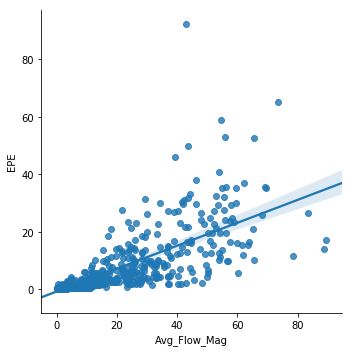

In [9]:
# Is there a correlation between average flow magnitude and EPE?
sns.lmplot(x='Avg_Flow_Mag', y='EPE', data=df, fit_reg=True)

In [10]:
# Which are the 10 worst performers by EPE?
df = df.sort_values(by='EPE')
df_worst = df.tail(num_samples).iloc[::-1]
df_worst

ID        EPE  Duration  Avg_Flow_Mag  \
706   ambush_4/frames_0004_0005  92.472389  0.075795     42.891090   
1003  ambush_4/frames_0005_0006  65.259903  0.073802     73.527435   
584   ambush_2/frames_0015_0016  59.103275  0.073803     54.388008   
933     cave_2/frames_0025_0026  53.172447  0.074800     55.848892   
791   ambush_6/frames_0015_0016  52.629745  0.073802     65.354340   
201   ambush_2/frames_0014_0015  50.045570  0.072805     43.488350   
237   ambush_4/frames_0007_0008  45.879726  0.072806     39.206539   
729   ambush_5/frames_0048_0049  40.856850  0.074801     53.794697   
850   market_5/frames_0014_0015  37.920662  0.073803     46.108120   
71    temple_3/frames_0041_0042  36.918785  0.073803     62.158405   

      Max_Flow_Mag  
706     130.056442  
1003    186.482361  
584      87.956146  
933     108.098312  
791     181.815704  
201     103.059151  
237     101.608582  
729     194.806168  
850     121.596130  
71      144.826828

In [11]:
mean_avg_flow_mag = df['Avg_Flow_Mag'].mean()
mean_avg_flow_mag

11.967922369839478

In [12]:
# Which are the 10 best performers with an average flow magnitude?
mean_avg_flow_mag = df['Avg_Flow_Mag'].mean()
df_best = df[df['Avg_Flow_Mag'] >= mean_avg_flow_mag].sort_values(by='EPE').head(int(num_samples))
df_best

ID       EPE  Duration  Avg_Flow_Mag  Max_Flow_Mag
728    cave_2/frames_0043_0044  0.940174  0.073802     23.228945     39.680443
551    cave_2/frames_0044_0045  0.957487  0.072806     16.528591     23.823107
520  temple_3/frames_0015_0016  1.147440  0.074824     12.096847     45.916409
177  temple_3/frames_0016_0017  1.315763  0.073803     13.364153     54.485172
443  temple_3/frames_0017_0018  1.344517  0.069813     14.518110     58.428246
234    cave_2/frames_0042_0043  1.492007  0.072824     31.523825     44.994095
627    cave_4/frames_0022_0023  1.507231  0.074812     13.264821     25.902044
361    cave_2/frames_0003_0004  1.616955  0.070835     13.814056     23.918205
533    cave_2/frames_0047_0048  1.650649  0.073802     12.435542     33.461140
832    cave_2/frames_0041_0042  1.669513  0.074819     36.871605     56.777035

# Visual assessment

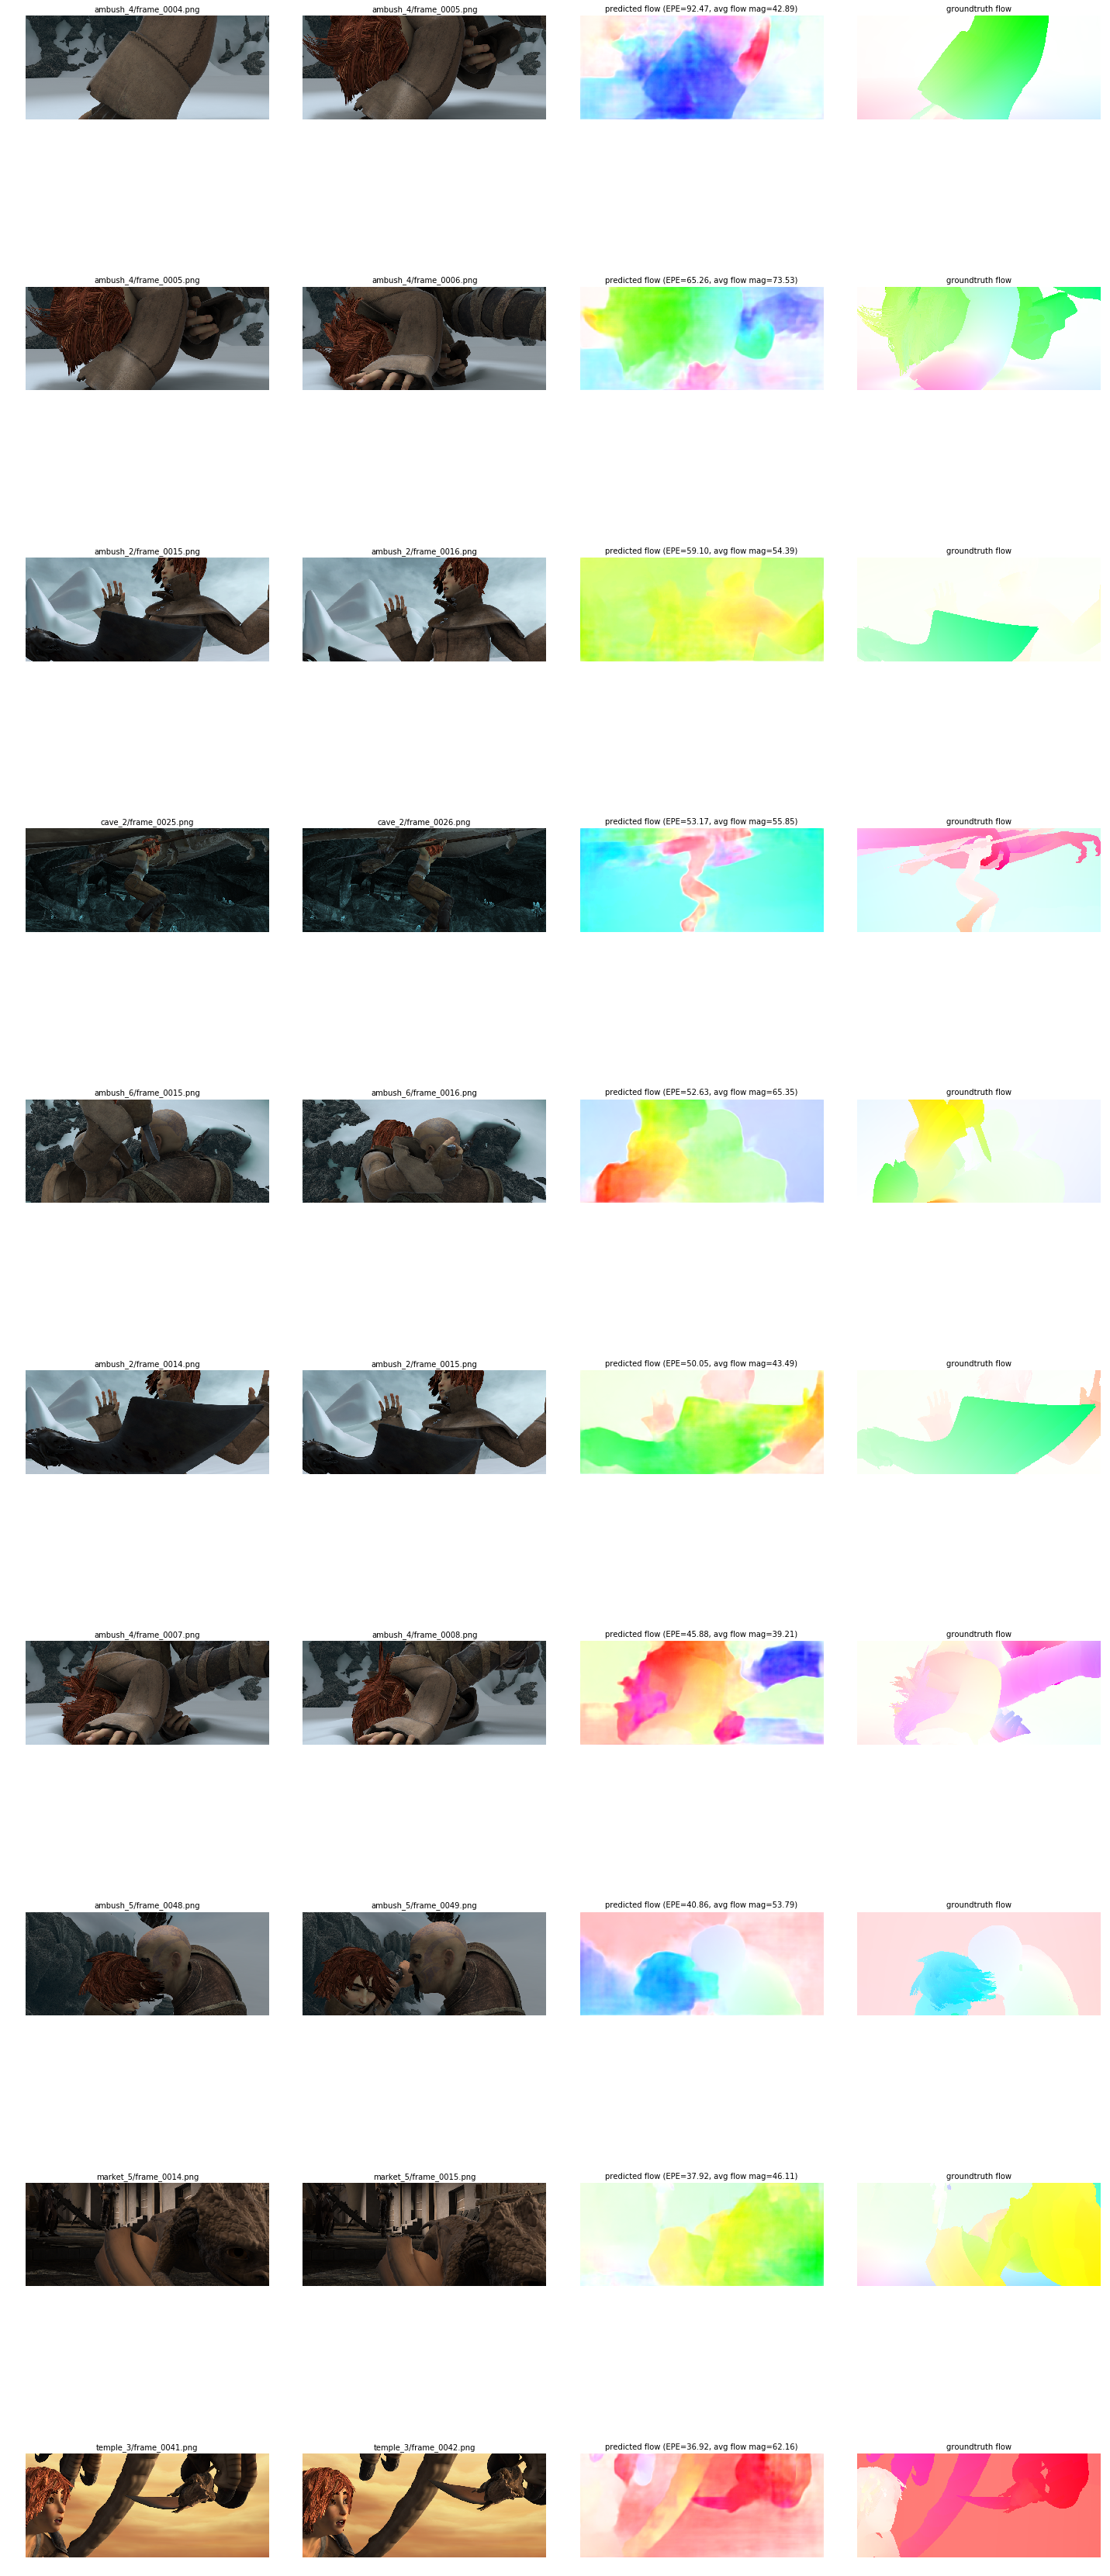

In [13]:
# How do the 10 worst performers look like?
images, labels, pred_labels, ids = ds.get_samples_by_flow_ID(list(df_worst['ID']), split='val_with_preds')
info_text = [f"(EPE={stat[0]:.2f}, avg flow mag={stat[1]:.2f})" for stat in zip(df_worst['EPE'], df_worst['Avg_Flow_Mag'])]
display_img_pairs_w_flows(images, pred_labels, labels, ids, info_text)

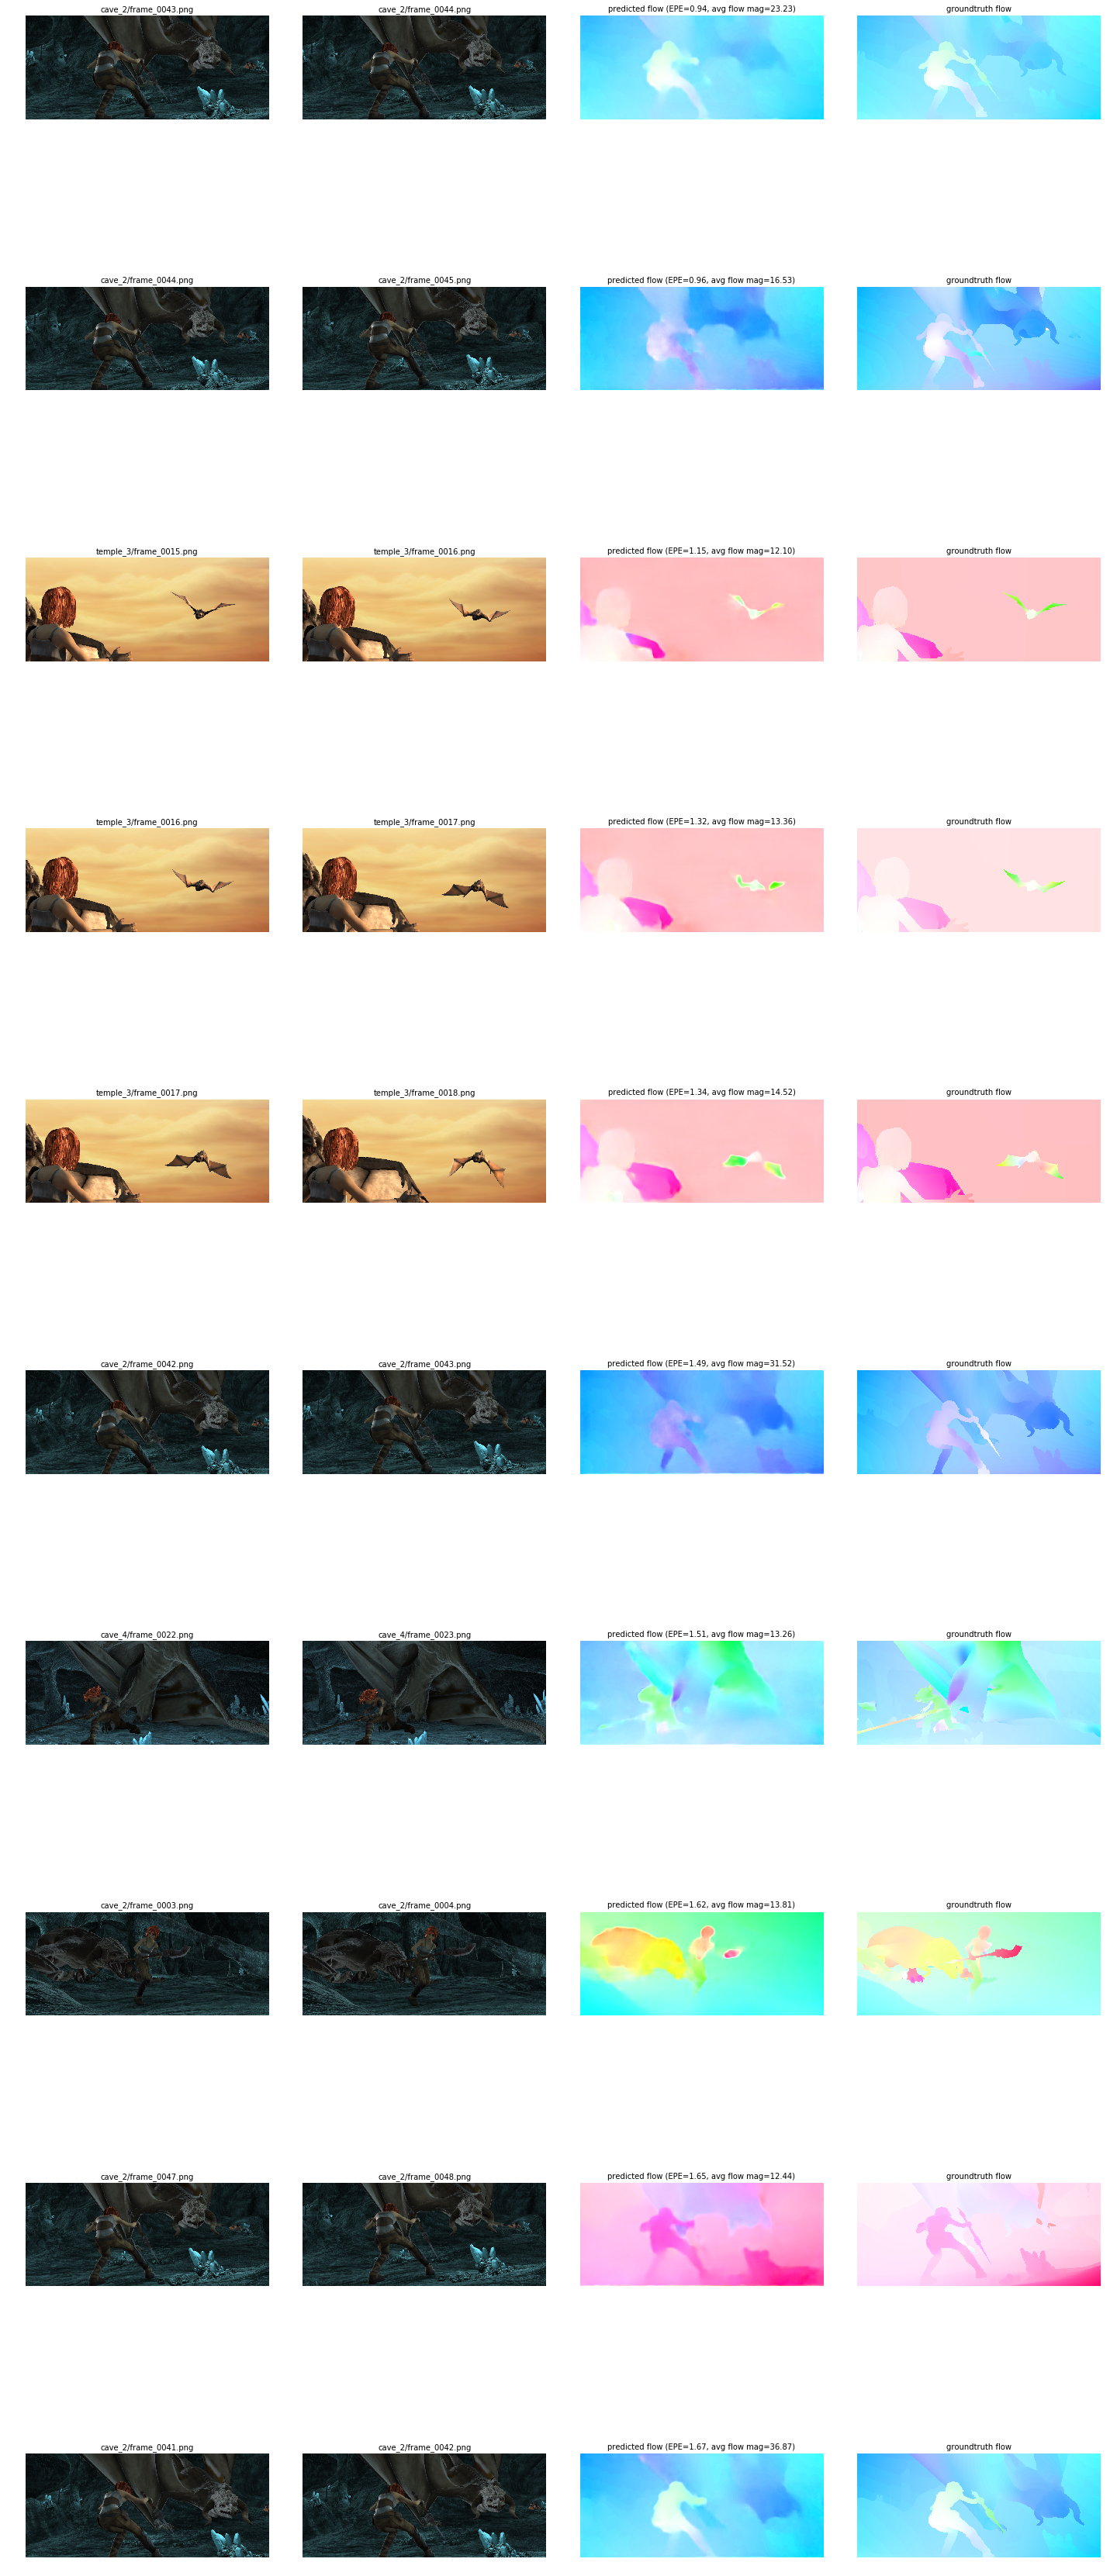

In [14]:
# How do the 10 best performers (with average flow mag) look like?
images, labels, pred_labels, ids = ds.get_samples_by_flow_ID(list(df_best['ID']), split='val_with_preds')
info_text = [f"(EPE={stat[0]:.2f}, avg flow mag={stat[1]:.2f})" for stat in zip(df_best['EPE'], df_best['Avg_Flow_Mag'])]
display_img_pairs_w_flows(images, pred_labels, labels, ids, info_text)